# We import all the required Libraries

In [45]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import tensorflow as tf
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer


## Importing the dataset for further analysis

In [2]:
df = pd.read_csv('archive/Resume/Resume.csv')

df.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

# Now we remove the unnecessary columns from our data frame

In [3]:
print(df.columns)

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')


# Checking for Null Values

In [4]:
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [5]:
# drropping the 'ID' and 'Resume_str' columns
df.drop(columns=['ID', 'Resume_html'], inplace=True)

df.head()

Resume_str Category
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1           HR SPECIALIST, US HR OPERATIONS      ...       HR
2           HR DIRECTOR       Summary      Over 2...       HR
3           HR SPECIALIST       Summary    Dedica...       HR
4           HR MANAGER         Skill Highlights  ...       HR

In [6]:
df.Category.value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

## Renaming the column named 'Resume_str' to 'Resume'

In [7]:
# renaming the column for ease of use
df = df.rename(columns={'Resume_str': 'Resume'})

df.head()

Resume Category
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1           HR SPECIALIST, US HR OPERATIONS      ...       HR
2           HR DIRECTOR       Summary      Over 2...       HR
3           HR SPECIALIST       Summary    Dedica...       HR
4           HR MANAGER         Skill Highlights  ...       HR

# Data Pre-processing function that will do all the required pre-processing

In [8]:
def data_preprocessing(text):
    # convert all characters in the string to lowercase
    text = text.lower()
    # remove non-English alphabets, punctuation, and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # remove all the URLs
    text = re.sub('http\S+\s*', ' ', text)
    # remove the RT and cc
    text = re.sub('RT|cc', ' ', text)
    # remove all the hashtags
    text = re.sub('#\S+', '', text)
    # remove all the mentions
    text = re.sub('@\S+', '  ', text)
    # remove all the extra whitespace
    text = re.sub('\s+', ' ', text)
    # tokenize the words
    words = nltk.tokenize.word_tokenize(text)
    # remove the stop words
    words = [word for word in words if word not in nltk.corpus.stopwords.words('english')]
    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

## Calling the data_preporcessing funciton

In [9]:
# preprocessing text
df['Resume'] = df['Resume'].apply(lambda x: data_preprocessing(x))

In [10]:
df['Resume'].iloc[0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager year experience hospitality customer service management respected builder leader customer focused team strives instill shared enthusiastic commitment customer service highlight focused customer satisfaction team management marketing savvy conflict resolution technique training development skilled multi tasker client relation specialist omplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification omplished trainer cross server hospitality system hilton onq micros opera pm fidelio opera reservation system or holidex completed course seminar customer service sale strategy inventory control loss prevention safety time management leadership performance assessment experience hr administrator marketing associate hr administrator dec current company name city state help develop policy directs co

# Performing Data Analysis

In [11]:
len(df)

2484

In [12]:
df.head()

Resume Category
0  hr administrator marketing associate hr admini...       HR
1  hr specialist u hr operation summary versatile...       HR
2  hr director summary year experience recruiting...       HR
3  hr specialist summary dedicated driven dynamic...       HR
4  hr manager skill highlight hr skill hr departm...       HR

In [13]:
# create list of all categories
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [14]:
df

Resume  Category
0     hr administrator marketing associate hr admini...        HR
1     hr specialist u hr operation summary versatile...        HR
2     hr director summary year experience recruiting...        HR
3     hr specialist summary dedicated driven dynamic...        HR
4     hr manager skill highlight hr skill hr departm...        HR
...                                                 ...       ...
2479  rank sgt e non commissioned officer charge bri...  AVIATION
2480  government relation communication organization...  AVIATION
2481  geek squad agent professional profile support ...  AVIATION
2482  program director office manager summary highly...  AVIATION
2483  storekeeper ii professional summary purpose do...  AVIATION

[2484 rows x 2 columns]

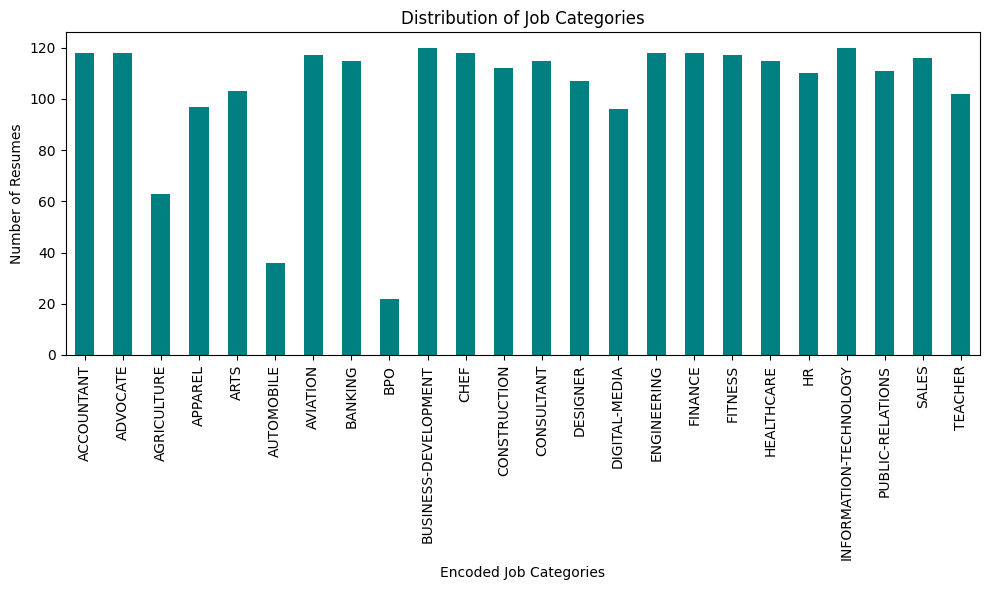

In [15]:
plt.figure(figsize=(10, 6))
df['Category'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.xlabel('Encoded Job Categories')
plt.ylabel('Number of Resumes')
plt.title('Distribution of Job Categories')
plt.tight_layout()
plt.show()


## Generating the word Cloud

In [35]:
def wordcloud(df):
    txt = ' '.join(txt for txt in df['Resume'])
    wordcloud = WordCloud(
        height=2000,
        width=4000,
    ).generate(txt)

    return wordcloud

In [36]:
# create new df for corpus and category
df_categories = [df[df['Category'] == category].loc[:, ['Resume', 'Category']] for category in categories]
df_categories[10]

Resume Category
1357  chef career focus nursing student recently obt...     CHEF
1358  chef summary customer oriented fast food worke...     CHEF
1359  chef career overview dedicated customer servic...     CHEF
1360  chef summary experienced catering chef skilled...     CHEF
1361  rm roxanne mejia summary motivating chef compe...     CHEF
...                                                 ...      ...
1470  owner chef summary chef year critically laimed...     CHEF
1471  kindergarten teacher professional summary ener...     CHEF
1472  substitute para professional summary professio...     CHEF
1473  executive chef partner summary proven ability ...     CHEF
1474  line chef expediter summary chef year experien...     CHEF

[118 rows x 2 columns]

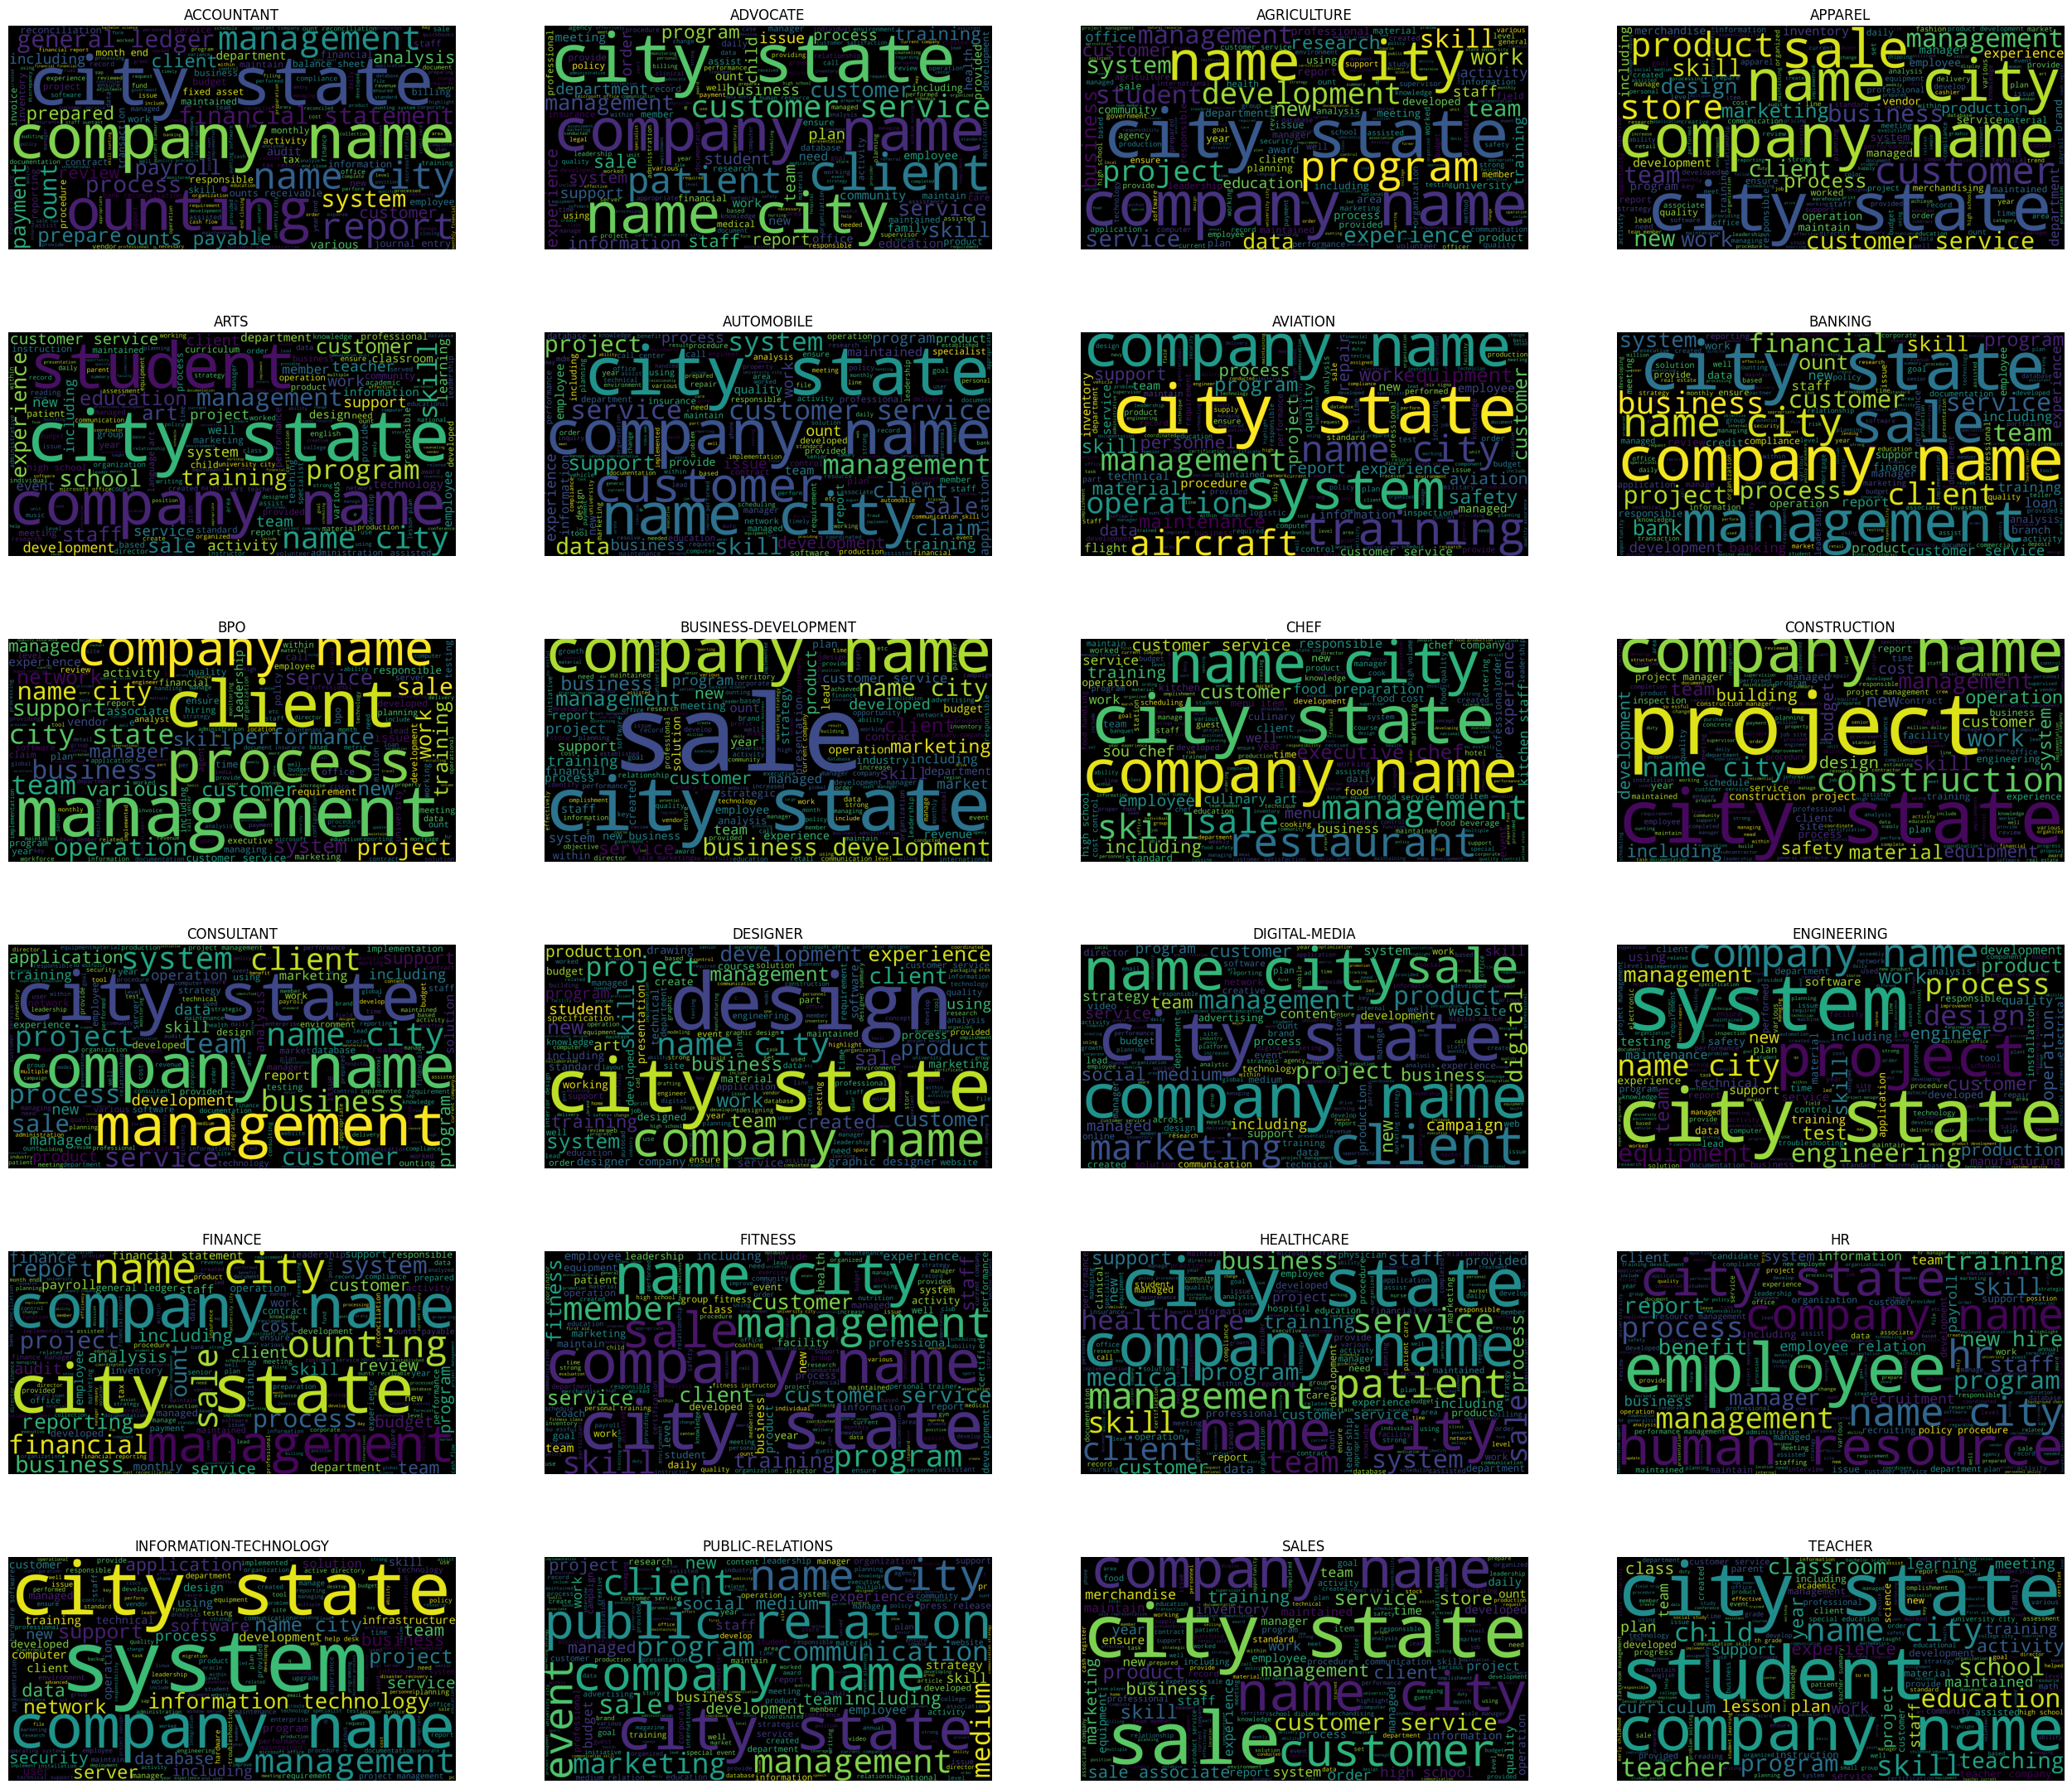

In [37]:
plt.figure(figsize=(32, 28))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(6, 4, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

## Wrod frequency table

In [38]:
def word_frequency_table(df):
    count = df['Resume'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']
    return count.head(10)

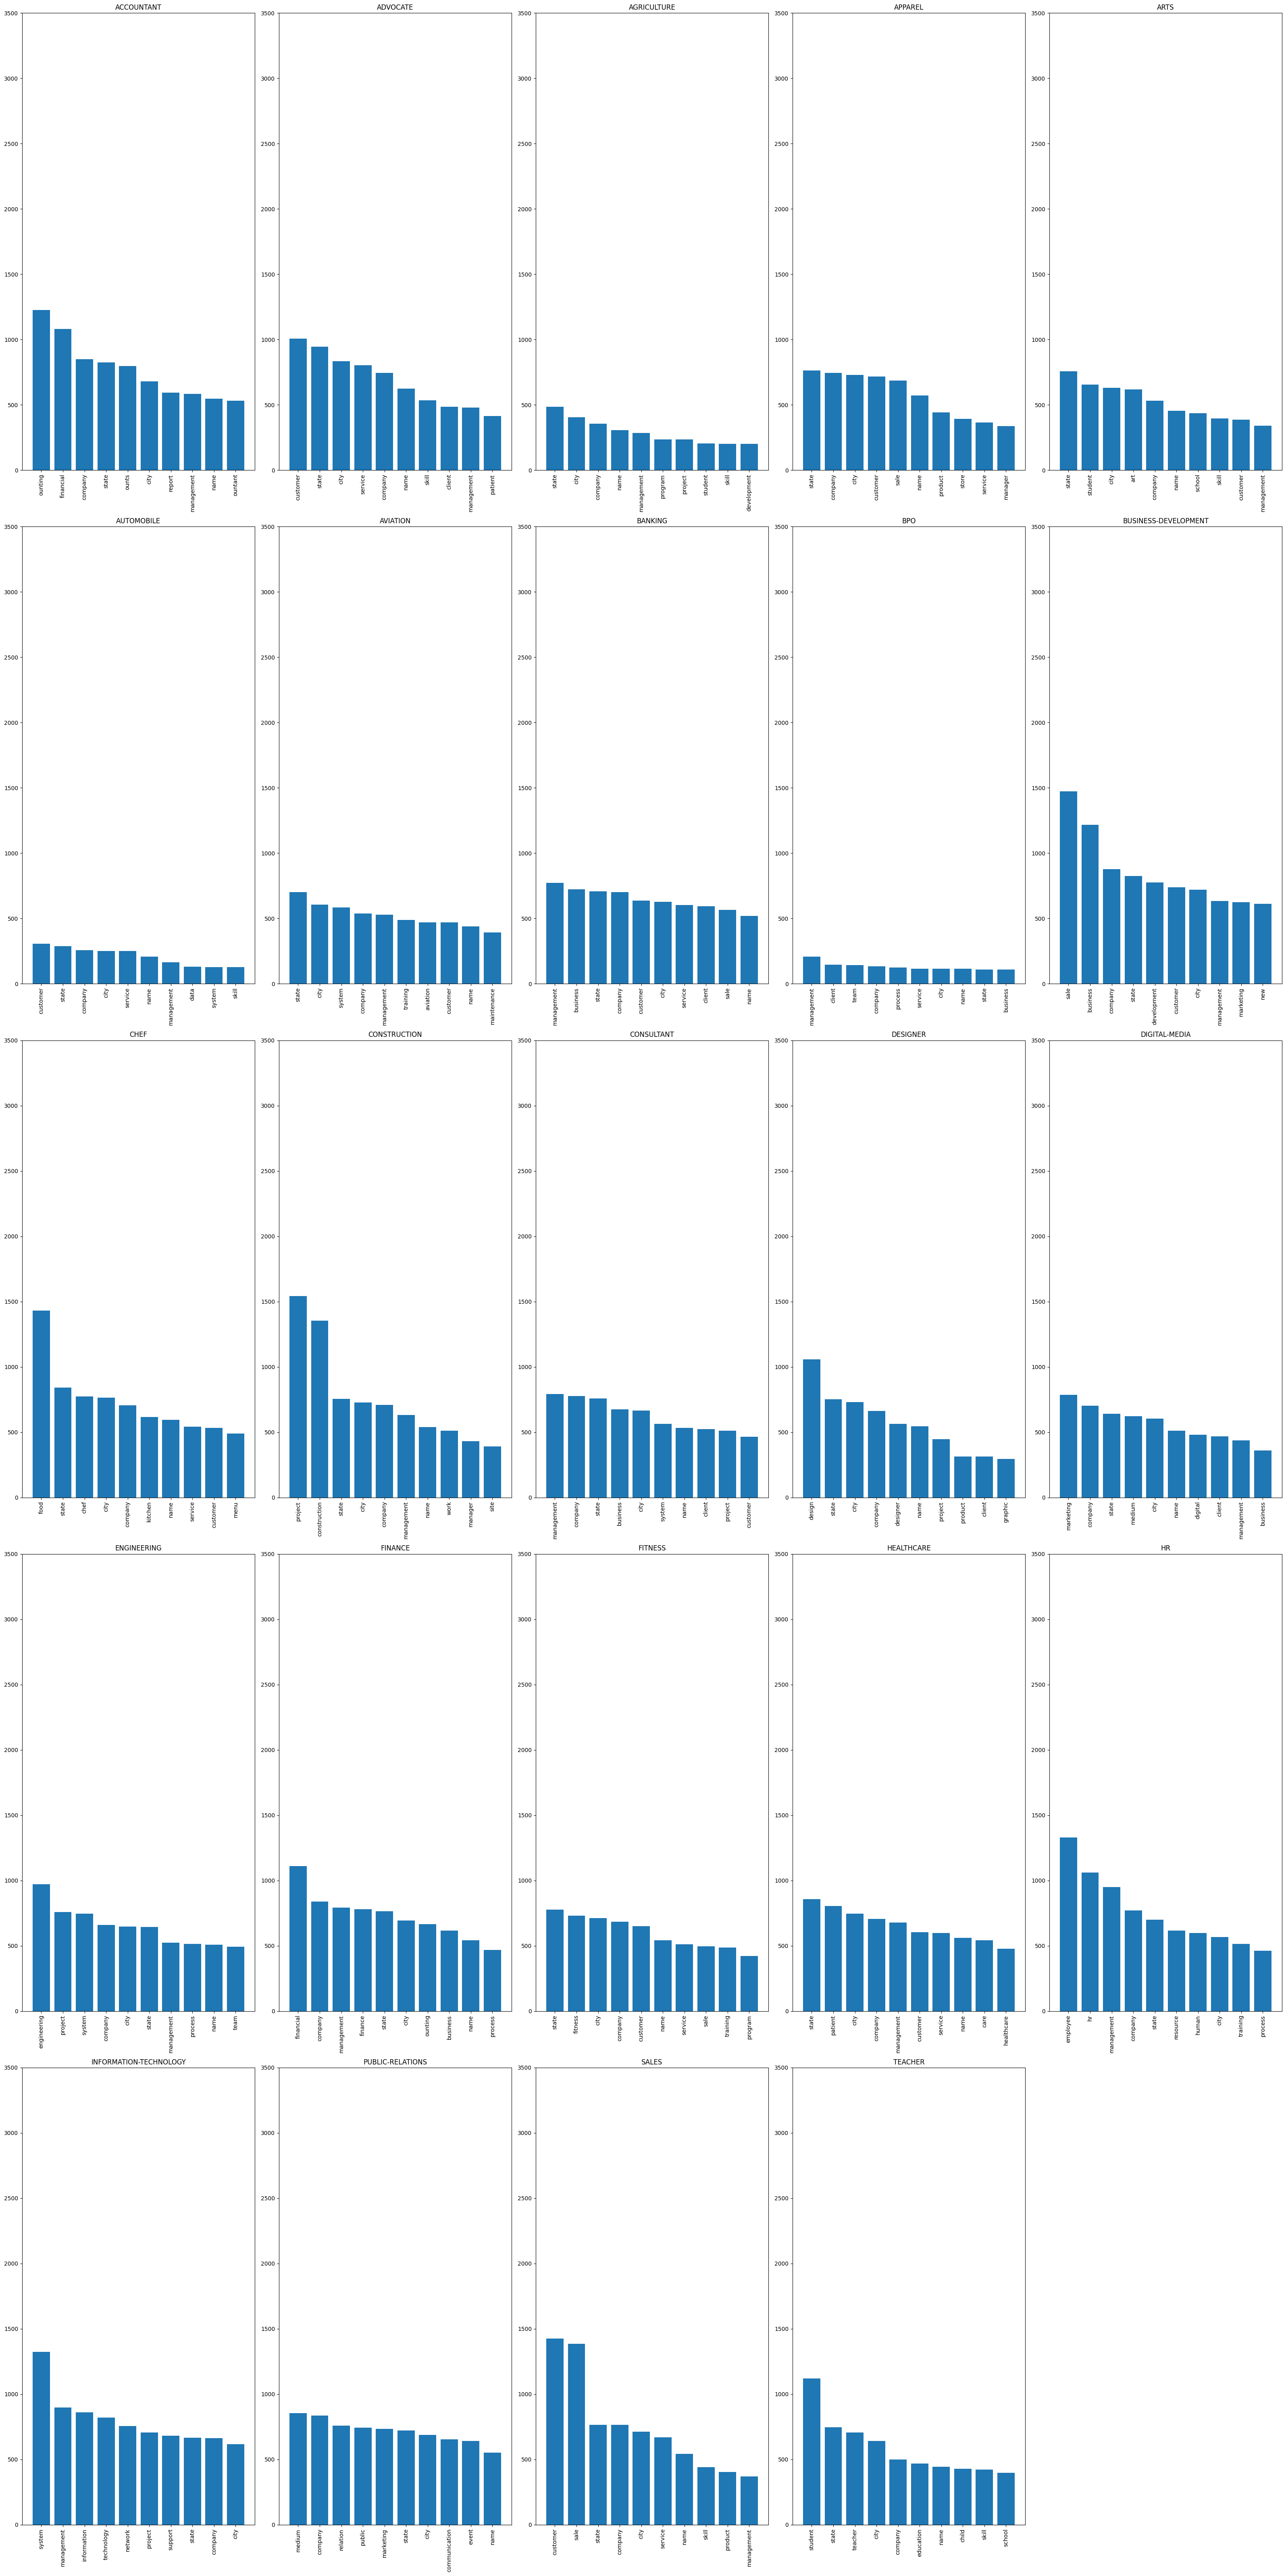

In [39]:
fig = plt.figure(figsize=(32, 64))

for i, category in enumerate(categories):
    wf = word_frequency_table(df_categories[i])

    ax = fig.add_subplot(5, 5, i + 1)
    ax.set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

    # Rotate y-axis labels
    plt.xticks(rotation=90)

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()
plt.close()

## Now we lable encode the categories column

In [40]:
# label encoder
le = LabelEncoder()

df['Category_Encoded'] = le.fit_transform(df['Category'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'ACCOUNTANT': 0, 'ADVOCATE': 1, 'AGRICULTURE': 2, 'APPAREL': 3, 'ARTS': 4, 'AUTOMOBILE': 5, 'AVIATION': 6, 'BANKING': 7, 'BPO': 8, 'BUSINESS-DEVELOPMENT': 9, 'CHEF': 10, 'CONSTRUCTION': 11, 'CONSULTANT': 12, 'DESIGNER': 13, 'DIGITAL-MEDIA': 14, 'ENGINEERING': 15, 'FINANCE': 16, 'FITNESS': 17, 'HEALTHCARE': 18, 'HR': 19, 'INFORMATION-TECHNOLOGY': 20, 'PUBLIC-RELATIONS': 21, 'SALES': 22, 'TEACHER': 23}


In [41]:
df

Resume  Category  \
0     hr administrator marketing associate hr admini...        HR   
1     hr specialist u hr operation summary versatile...        HR   
2     hr director summary year experience recruiting...        HR   
3     hr specialist summary dedicated driven dynamic...        HR   
4     hr manager skill highlight hr skill hr departm...        HR   
...                                                 ...       ...   
2479  rank sgt e non commissioned officer charge bri...  AVIATION   
2480  government relation communication organization...  AVIATION   
2481  geek squad agent professional profile support ...  AVIATION   
2482  program director office manager summary highly...  AVIATION   
2483  storekeeper ii professional summary purpose do...  AVIATION   

      Category_Encoded  
0                   19  
1                   19  
2                   19  
3                   19  
4                   19  
...                ...  
2479                 6  
2480                 6  
2481                 6  
2482                 6  
2483                 6  

[2484 rows x 3 columns]

In [42]:
df.Category.value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

# Count Vectorization

In [46]:
text = df['Resume'].values
clss = df['Category'].values

word_vectorizer = CountVectorizer(
    stop_words='english')
word_vectorizer.fit(text)
WordFeatures = word_vectorizer.transform(text)

X_train, X_test, y_train, y_test = train_test_split(WordFeatures, clss, random_state=42, test_size=0.2, shuffle=True, stratify=clss)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1987, 33211)
Shape of X_test: (497, 33211)
Shape of y_train: (1987,)
Shape of y_test: (497,)


# ML classifiers with Count vectorisation

C:\Users\usama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


                         Model  Train Accuracy  Test Accuracy
0          Logistic Regression        0.846502       0.615694
1  Logistic Regression with L1        0.734776       0.742455
2                Decision Tree        1.000000       0.571429
3                Random Forest        1.000000       0.639839
4                   Linear SVM        0.999497       0.688129
5                          SVM        0.991948       0.593561


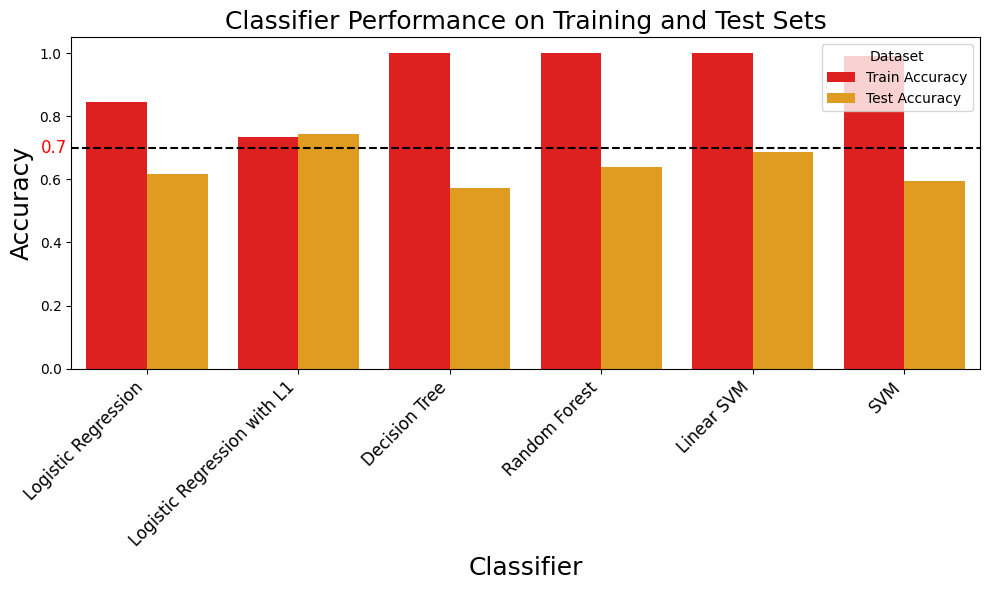

In [52]:
# define all the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression with L1": LogisticRegression(penalty='l1', solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150),
    "Linear SVM": LinearSVC(max_iter=10000),
    "SVM": SVC(kernel='rbf')
}


results = []

# itterating all over classifiers
for clf_name, clf in classifiers.items():

    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    results.append({"Model": clf_name, "Train Accuracy": train_acc, "Test Accuracy": test_acc})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)

# Plotting with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Dataset", value_name="Accuracy"), x="Model", y="Accuracy", hue="Dataset", palette=colors)
plt.title("Classifier Performance on Training and Test Sets", fontsize=18)
plt.xlabel("Classifier", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.axhline(y=0.7, color='black', linestyle='--')  # Add a dotted line at y=0.7
plt.text(-0.7, 0.7, '0.7', color='red', fontsize=12, va='center')  # Add text annotation at left of the line
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# Performing Grid Search

In [49]:
# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_forest_clf = grid_search.best_estimator_

forest_train_acc = accuracy_score(y_train, best_forest_clf.predict(X_train))
forest_test_acc = accuracy_score(y_test, best_forest_clf.predict(X_test))
print("Random Forest with Grid Search - Train Accuracy:", forest_train_acc)
print("Random Forest with Grid Search - Test Accuracy:", forest_test_acc)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Random Forest with Grid Search - Train Accuracy: 0.984398590840463
Random Forest with Grid Search - Test Accuracy: 0.6257545271629779


# TF-idf with ML models

C:\Users\usama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


                         Model  Train Accuracy  Test Accuracy
0          Logistic Regression        0.846502       0.615694
1  Logistic Regression with L1        0.735279       0.742455
2       Multinomail LR with L1        0.846502       0.615694
3                Decision Tree        1.000000       0.563380
4                Random Forest        0.958732       0.621730
5                   Linear SVM        0.999497       0.688129
6                          SVM        0.991948       0.593561


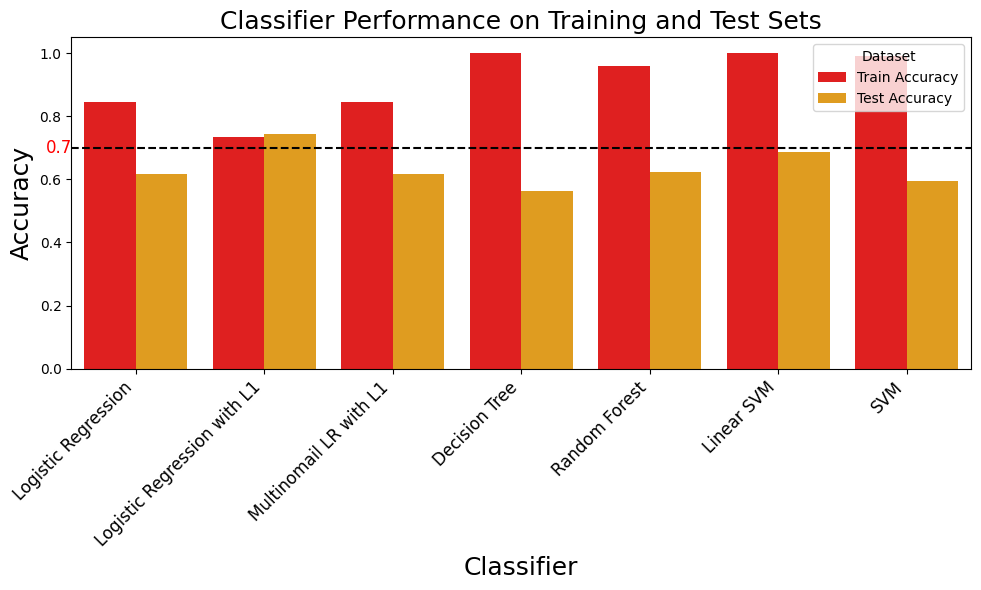

In [51]:
# TF-IDF Vectorization
text = df['Resume'].values
clss = df['Category_Encoded'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english')
word_vectorizer.fit(text)
WordFeatures = word_vectorizer.transform(text)


X_train, X_test, y_train, y_test = train_test_split(WordFeatures, clss, random_state=42, test_size=0.2, shuffle=True, stratify=clss)

# defining all of the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression with L1": LogisticRegression(penalty='l1', solver='liblinear'),
    "Multinomail LR with L1": LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150),
    "Linear SVM": LinearSVC(max_iter=10000),
    "SVM": SVC()
}

results = []

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    results.append({"Model": clf_name, "Train Accuracy": train_acc, "Test Accuracy": test_acc})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)

# define custom colors for train and test plots
colors = ['red', "orange"]  # Blue for train, Orange for test

# plotting the result
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Dataset", value_name="Accuracy"), x="Model", y="Accuracy", hue="Dataset", palette=colors)
plt.title("Classifier Performance on Training and Test Sets", fontsize=18)
plt.xlabel("Classifier", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.axhline(y=0.7, color='black', linestyle='--')  # Add a dotted line at y=0.7
plt.text(-0.7, 0.7, '0.7', color='red', fontsize=12, va='center')  # Add text annotation at left of the line
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


# Performing Grid search

In [53]:
# Ddefiign the grid search parameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

forest_clf = RandomForestClassifier()

grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_forest_clf = grid_search.best_estimator_

forest_train_acc = accuracy_score(y_train, best_forest_clf.predict(X_train))
forest_test_acc = accuracy_score(y_test, best_forest_clf.predict(X_test))
print("Random Forest with Grid Search - Train Accuracy:", forest_train_acc)
print("Random Forest with Grid Search - Test Accuracy:", forest_test_acc)


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Random Forest with Grid Search - Train Accuracy: 0.8671363865123302
Random Forest with Grid Search - Test Accuracy: 0.5995975855130785


# Bagging Classifier

In [55]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(n_estimators=50,random_state=2)
bagging_clf.fit(X_train, y_train)

bagging_prediction = bagging_clf.predict(X_test)

# computing and printing the accuracy
bagging_train_accuracy = accuracy_score(y_train, bagging_clf.predict(X_train))
bagging_test_accuracy = accuracy_score(y_test, bagging_prediction)
print('Accuracy of Bagging Classifier on training set: {:.2f}'.format(bagging_train_accuracy))
print('Accuracy of Bagging Classifier on test set: {:.2f}'.format(bagging_test_accuracy))


Accuracy of Bagging Classifier on training set: 1.00
Accuracy of Bagging Classifier on test set: 0.72


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boosting_clf = GradientBoostingClassifier(n_estimators=50,random_state=2)
gradient_boosting_clf.fit(X_train, y_train)

gradient_boosting_prediction = gradient_boosting_clf.predict(X_test)

# computing and printing the accuracy
gradient_boosting_train_accuracy = accuracy_score(y_train, gradient_boosting_clf.predict(X_train))
gradient_boosting_test_accuracy = accuracy_score(y_test, gradient_boosting_prediction)
print('Accuracy of Gradient Boosting Classifier on training set: {:.2f}'.format(gradient_boosting_train_accuracy))
print('Accuracy of Gradient Boosting Classifier on test set: {:.2f}'.format(gradient_boosting_test_accuracy))


# Implementing Neural networks

# Feed forward Neural Network with Tf-IDF

In [56]:
# prepare the data
X = df['Resume'].values
y = df['Category_Encoded'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=6000)  # Define max_features based on your preference

# fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# transforming the testing data 
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# defining the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],), dtype='float32'), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax')
])

#compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')




Epoch 1/10


25/25 [==============================] - 2s 18ms/step - loss: 3.1266 - accuracy: 0.2209 - val_loss: 3.0453 - val_accuracy: 0.4673
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 2.8972 - accuracy: 0.5142 - val_loss: 2.8295 - val_accuracy: 0.5025
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 2.6043 - accuracy: 0.5890 - val_loss: 2.5719 - val_accuracy: 0.5302
Epoch 4/10
25/25 [==============================] - 0s 10ms/step - loss: 2.2659 - accuracy: 0.6432 - val_loss: 2.3117 - val_accuracy: 0.5452
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 1.9455 - accuracy: 0.6658 - val_loss: 2.0771 - val_accuracy: 0.5603
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 1.6870 - accuracy: 0.6935 - val_loss: 1.8967 - val_accuracy: 0.5804
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 1.4584 - accuracy: 0.7250 - val_loss: 1.7592 - val_accuracy: 0.5930
Epoch 8/10
2

# Recurrent Neural Network

## with tokenisation

In [57]:

# tokenizing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# padding sequences to ensure uniform length
max_sequence_length = 300  # You can adjust this based on your data and task requirements
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# defining the RNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax') 
])

# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 5s 124ms/step - loss: 3.2818 - accuracy: 0.0428 - val_loss: 3.1744 - val_accuracy: 0.0578
Epoch 2/10
25/25 [==============================] - 3s 112ms/step - loss: 3.1746 - accuracy: 0.0579 - val_loss: 3.1549 - val_accuracy: 0.0628
Epoch 3/10
25/25 [==============================] - 3s 105ms/step - loss: 3.1503 - accuracy: 0.0554 - val_loss: 3.1636 - val_accuracy: 0.0528
Epoch 4/10
25/25 [==============================] - 2s 95ms/step - loss: 3.1224 - accuracy: 0.0598 - val_loss: 3.1499 - val_accuracy: 0.0477
Epoch 5/10
25/25 [==============================] - 2s 98ms/step - loss: 3.0845 - accuracy: 0.0925 - val_loss: 3.1405 - val_accuracy: 0.0854
Epoch 6/10
25/25 [==============================] - 2s 97ms/step - loss: 3.0448 - accuracy: 0.1001 - val_loss: 3.1354 - val_accuracy: 0.0829
Epoch 7/10
25/25 [==============================] - 2s 96ms/step - loss: 3.0061 - accuracy: 0.1095 - val_loss: 3.1219 - val_accuracy: 0.0980
Epoch 8/10

## rnn with count vectorisation

In [65]:
X = df['Resume'].values 
y = df['Category_Encoded'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=6000)  # Define max_features based on your preference

X_train_count = count_vectorizer.fit_transform(X_train).toarray()

X_test_count = count_vectorizer.transform(X_test).toarray()

# defining the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_count.shape[1],)),  
    tf.keras.layers.Reshape((1, X_train_count.shape[1])),  
    tf.keras.layers.SimpleRNN(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))  
])



# compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_count, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_count, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 2s 23ms/step - loss: 4.8185 - accuracy: 0.2385 - val_loss: 3.5507 - val_accuracy: 0.5101
Epoch 2/10
25/25 [==============================] - 0s 11ms/step - loss: 3.0410 - accuracy: 0.5960 - val_loss: 2.8533 - val_accuracy: 0.5930
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 2.2992 - accuracy: 0.7218 - val_loss: 2.5643 - val_accuracy: 0.6206
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: 1.8868 - accuracy: 0.8162 - val_loss: 2.4010 - val_accuracy: 0.6357
Epoch 5/10
25/25 [==============================] - 0s 11ms/step - loss: 1.5890 - accuracy: 0.8767 - val_loss: 2.2982 - val_accuracy: 0.6533
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 1.4294 - accuracy: 0.9132 - val_loss: 2.2080 - val_accuracy: 0.6407
Epoch 7/10
25/25 [==============================] - 0s 11ms/step - loss: 1.2927 - accuracy: 0.9327 - val_loss: 2.1630 - val_accuracy: 0.6558
Epoch 8/10
25

## RNN with tf-idf

In [67]:
X = df['Resume'].values
y = df['Category_Encoded'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=6000)  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# transforming the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# defining the model SimpleRNN
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],)),  
    tf.keras.layers.Reshape((1, X_train_tfidf.shape[1])),  
    tf.keras.layers.SimpleRNN(128, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax')  # Output layer
])

# compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 2s 21ms/step - loss: 3.1330 - accuracy: 0.1687 - val_loss: 3.0513 - val_accuracy: 0.3291
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 2.9070 - accuracy: 0.4764 - val_loss: 2.8248 - val_accuracy: 0.4799
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 2.5979 - accuracy: 0.5532 - val_loss: 2.5579 - val_accuracy: 0.5251
Epoch 4/10
25/25 [==============================] - 0s 10ms/step - loss: 2.2587 - accuracy: 0.6155 - val_loss: 2.2935 - val_accuracy: 0.5377
Epoch 5/10
25/25 [==============================] - 0s 10ms/step - loss: 1.9608 - accuracy: 0.6658 - val_loss: 2.0591 - val_accuracy: 0.5678
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 1.7087 - accuracy: 0.6828 - val_loss: 1.8863 - val_accuracy: 0.5905
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 1.4982 - accuracy: 0.7212 - val_loss: 1.7476 - val_accuracy: 0.5854
Epoch 8/10
25/

## RNN with word2vec

In [68]:
X = df['Resume'].values  
y = df['Category_Encoded'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the Word2Vec model
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

# converting resumes to word embeddings
X_train_embedded = []
for resume in X_train:
    embedded_resume = []
    for word in resume.split():
        if word in word2vec_model.wv:
            embedded_resume.append(word2vec_model.wv[word])
    X_train_embedded.append(embedded_resume)

X_test_embedded = []
for resume in X_test:
    embedded_resume = []
    for word in resume.split():
        if word in word2vec_model.wv:
            embedded_resume.append(word2vec_model.wv[word])
    X_test_embedded.append(embedded_resume)

# padding the sequences for input to RNN
max_length = max(len(resume) for resume in X_train_embedded)
X_train_padded = pad_sequences(X_train_embedded, maxlen=max_length, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test_embedded, maxlen=max_length, padding='post', dtype='float32')

# defining the model architecture SImple RNN
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length, 100)),  
    tf.keras.layers.SimpleRNN(128, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax')  
])

# compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training  the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 2s 34ms/step - loss: 3.1756 - accuracy: 0.0365 - val_loss: 3.1647 - val_accuracy: 0.0427
Epoch 2/10
25/25 [==============================] - 1s 24ms/step - loss: 3.1679 - accuracy: 0.0447 - val_loss: 3.1598 - val_accuracy: 0.0503
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 3.1574 - accuracy: 0.0497 - val_loss: 3.1498 - val_accuracy: 0.0276
Epoch 4/10
25/25 [==============================] - 1s 24ms/step - loss: 3.1510 - accuracy: 0.0592 - val_loss: 3.1597 - val_accuracy: 0.0503
Epoch 5/10
25/25 [==============================] - 1s 25ms/step - loss: 3.1534 - accuracy: 0.0384 - val_loss: 3.1473 - val_accuracy: 0.0503
Epoch 6/10
25/25 [==============================] - 1s 25ms/step - loss: 3.1538 - accuracy: 0.0403 - val_loss: 3.1518 - val_accuracy: 0.0503
Epoch 7/10
25/25 [==============================] - 1s 24ms/step - loss: 3.1524 - accuracy: 0.0428 - val_loss: 3.1497 - val_accuracy: 0.0276
Epoch 8/10
25

# Bidirection LSTM with TF-IDF

In [72]:
X = df['Resume'].values
y = df['Category_Encoded'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=6000)  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# transforming the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# define the model architecture with bidrectional rnn
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],)),  
    tf.keras.layers.Reshape((1, X_train_tfidf.shape[1])), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu')), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax')  
])

# compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 4s 78ms/step - loss: 3.1562 - accuracy: 0.2454 - val_loss: 3.1185 - val_accuracy: 0.4598
Epoch 2/10
25/25 [==============================] - 1s 57ms/step - loss: 3.0387 - accuracy: 0.5324 - val_loss: 2.9778 - val_accuracy: 0.4874
Epoch 3/10
25/25 [==============================] - 1s 56ms/step - loss: 2.7983 - accuracy: 0.5727 - val_loss: 2.7149 - val_accuracy: 0.4874
Epoch 4/10
25/25 [==============================] - 1s 55ms/step - loss: 2.4062 - accuracy: 0.6174 - val_loss: 2.3432 - val_accuracy: 0.5176
Epoch 5/10
25/25 [==============================] - 1s 54ms/step - loss: 1.9452 - accuracy: 0.6501 - val_loss: 1.9964 - val_accuracy: 0.5452
Epoch 6/10
25/25 [==============================] - 1s 54ms/step - loss: 1.5481 - accuracy: 0.7149 - val_loss: 1.7450 - val_accuracy: 0.5779
Epoch 7/10
25/25 [==============================] - 1s 55ms/step - loss: 1.2573 - accuracy: 0.7407 - val_loss: 1.5898 - val_accuracy: 0.5854
Epoch 8/10
25

# Long Short Term Memory (LSTM) with TF-IDF

In [73]:

# define the model architecture with LSTM and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_tfidf.shape[1],)),  
    tf.keras.layers.Reshape((1, X_train_tfidf.shape[1])),  
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),  
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.LSTM(64, activation='relu'),  
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(np.max(y) + 1, activation='softmax')  
])

# compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training the model
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.2)

# evaluating the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/10
25/25 [==============================] - 3s 45ms/step - loss: 3.1765 - accuracy: 0.0535 - val_loss: 3.1742 - val_accuracy: 0.1558
Epoch 2/10
25/25 [==============================] - 1s 30ms/step - loss: 3.1680 - accuracy: 0.1309 - val_loss: 3.1620 - val_accuracy: 0.2035
Epoch 3/10
25/25 [==============================] - 1s 30ms/step - loss: 3.1407 - accuracy: 0.1926 - val_loss: 3.1217 - val_accuracy: 0.2412
Epoch 4/10
25/25 [==============================] - 1s 30ms/step - loss: 3.0491 - accuracy: 0.1982 - val_loss: 2.9665 - val_accuracy: 0.2462
Epoch 5/10
25/25 [==============================] - 1s 30ms/step - loss: 2.7724 - accuracy: 0.2662 - val_loss: 2.5894 - val_accuracy: 0.3241
Epoch 6/10
25/25 [==============================] - 1s 30ms/step - loss: 2.4200 - accuracy: 0.3329 - val_loss: 2.2420 - val_accuracy: 0.4447
Epoch 7/10
25/25 [==============================] - 1s 30ms/step - loss: 2.1290 - accuracy: 0.4242 - val_loss: 2.0372 - val_accuracy: 0.5176
Epoch 8/10
25